In [85]:
import numpy as np
import itertools as it
from tqdm import tqdm
from matplotlib import pyplot as plt

In [86]:
# dummy sequence (binary for a start)
t = np.arange(100)
yBinaryTrue = np.zeros(100)
yBinaryTrue[6:28+1] = 1 #u1
yBinaryTrue[52:56+1] = 1 #u2
yBinaryTrue[71:80+1] = 1 #u3
yBinaryTrue[85:89+1] = 1 #u4
yBinaryPred = np.zeros(100)
yBinaryPred[10:16+1] = 1 #u1
yBinaryPred[19:30+1] = 1 #u2
yBinaryPred[51:58+1] = 1 #u3

In [87]:
np.sum((yBinaryTrue==1)*(yBinaryPred==0))

21

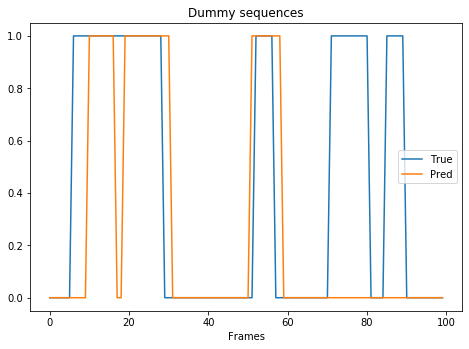

In [88]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(t,yBinaryTrue,label='True')
ax.plot(t,yBinaryPred,label='Pred')
ax.set_title('Dummy sequences')
ax.set_xlabel('Frames')
ax.legend()
plt.show()

In [256]:
import numpy as np
import sys
import itertools as it

def framewiseAccuracy(dataTrue, dataPred, trueIsCat, predIsCatOrProb, idxNotSeparation=np.array([])):
    """
        Computes accuracy of predictions wrt annotations.

        Inputs:
            dataTrue: a numpy array of annotations, shape [timeSteps] (values are classes)
                or [timeSteps, nbClasses] (categorical data)
            dataPred: a numpy array of predictions, shape [timeSteps] (values are classes),
                or [timeSteps, nbClasses] (probabilities or categorical)
            trueIsCat, predIsCatOrProb: bool
            idxNotSeparation: binary vector indicating where separations are (0)

        Outputs:
            a single accuracy value
    """

    dataIsSeparated = (idxNotSeparation.size > 0)

    if not trueIsCat:
        if len(dataTrue.shape) > 1:
            if dataTrue.shape[1] > 1:
                sys.exit('True data should be a vector (not categorical) because trueIsCat=False')
    if not predIsCatOrProb:
        if len(dataPred.shape) > 1:
            if dataPred.shape[1] > 1:
                sys.exit('Pred data should be a vector (not categorical or probabilities) because predIsCatOrProb=False')

    if dataIsSeparated:
        dataTrue = dataTrue[idxNotSeparation]
        dataPred = dataPred[idxNotSeparation]

    trueLength = dataTrue.shape[0]
    predLength = dataPred.shape[0]

    if trueLength != predLength:
        sys.exit('Annotation and prediction data should have the same length')
    if trueIsCat:
        dataTrue = np.argmax(dataTrue,axis=1)
    if predIsCatOrProb:
        dataPred = np.argmax(dataPred,axis=1)

    return np.sum(dataTrue == dataPred)/trueLength

def framewiseAccuracyYanovich(dataTrue, dataPred, trueIsCat):
    """
        Computes accuracy of predictions wrt annotations, as defined in Yanovich et al.

        Inputs:
            dataTrue: a numpy array of annotations, shape [timeSteps] (values are classes)
                or [timeSteps, nbClasses] (categorical data)
            dataPred: a numpy array of predictions, shape [timeSteps, nbClasses] (probabilities or categorical)
            trueIsCat: bool
            idxNotSeparation: binary vector indicating where separations are (0)

        Outputs:
            a single accuracy value, and the accuracy per class (array)
    """

    if not trueIsCat:
        if len(dataTrue.shape) > 1:
            if dataTrue.shape[1] > 1:
                sys.exit('True data should be a vector (not categorical) because trueIsCat=False')


    trueLength = dataTrue.shape[0]
    predLength = dataPred.shape[0]

    nClasses = dataPred.shape[1]

    if trueLength != predLength:
        sys.exit('Annotation and prediction data should have the same length')
    if trueIsCat:
        dataTrue = np.argmax(dataTrue[:,1:],axis=1)
    else:
        dataTrue = dataTrue - 1
    dataPred = np.argmax(dataPred[:,1:],axis=1)

    timestepsPerClass = np.zeros(nClasses-1)
    accPerClass = np.zeros(nClasses-1)
    for iC in range(nClasses-1):
        trueC = (dataTrue == iC)
        predC = (dataPred == iC)
        trueAndPredC = np.sum(trueC * predC)
        timestepsPerClass[iC] = np.sum(trueC)
        accPerClass[iC] = trueAndPredC/timestepsPerClass[iC]

    timestepsTotalNotZero = np.sum(timestepsPerClass)

    return np.sum(timestepsPerClass*accPerClass)/timestepsTotalNotZero, accPerClass



def framewisePRF1(dataTrue, dataPred, trueIsCat, predIsCatOrProb, idxNotSeparation=np.array([])):
    """
        Computes precision, recall and f1-score of predictions wrt annotations.
        Framewise.
        Data must be binary.

        Inputs:
            dataTrue: a numpy array of annotations, shape [timeSteps] (values are classes)
                or [timeSteps, 2] (categorical data)
            dataPred: a numpy array of predictions, shape [timeSteps] (values are classes),
                or [timeSteps, 2] (probabilities or categorical)
            trueIsCat, predIsCatOrProb: bool (if annotations are categorical,
                if predictions are categorical/probability values for each category)
            idxNotSeparation: binary vector indicating where separations are (0)
        Outputs:
            a single accuracy value
    """

    trueLength = dataTrue.shape[0]
    predLength = dataPred.shape[0]

    if not trueIsCat:
        if len(dataTrue.shape) > 1:
            if dataTrue.shape[1] > 1:
                sys.exit('True data should be a vector (not categorical) because trueIsCat=False')
    if not predIsCatOrProb:
        if len(dataPred.shape) > 1:
            if dataPred.shape[1] > 1:
                sys.exit('Pred data should be a vector (not categorical or probabilities) because predIsCatOrProb=False')

    if trueLength != predLength:
        sys.exit('Annotation and prediction data should have the same length')
    if np.max(dataTrue) > 1 or np.max(dataPred) > 1:
        sys.exit('Binary data required')
    if trueIsCat:
        if dataTrue.shape[1] > 2:
            sys.exit('Binary data required (2 classes)')
    if predIsCatOrProb:
        if dataPred.shape[1] > 2:
            sys.exit('Binary data required (2 classes)')
    if trueIsCat:
        dataTrue = np.argmax(dataTrue,axis=1)
    if predIsCatOrProb:
        dataPred = np.argmax(dataPred,axis=1)

    if dataIsSeparated:
        dataTrue = dataTrue[idxNotSeparation]
        dataPred = dataPred[idxNotSeparation]

    TP = np.sum(dataTrue*dataPred)
    FP = np.sum((1-dataTrue)*dataPred)
    TN = np.sum((1-dataTrue)*(1-dataPred))
    FN = np.sum(dataTrue*(1-dataPred))

    if TP+FP > 0:
        P = TP/(TP+FP)
    else:
        P = 0

    if TP+FN > 0:
        R = TP/(TP+FN)
    else:
        R = 0

    if P+R > 0:
        F1 = 2*P*R/(P+R)
    else:
        F1 = 0

    return P, R, F1

def oldPRF1(dataTrue, dataPred, trueIsCat, predIsCatOrProb, threshold):
    """
        Computes precision, recall and f1-score of predictions wrt annotations.
        Positives/negatives are counted within a window of +/- threshold,
        comparing the start of each unit.
        Data must be binary.

        Inputs:
            dataTrue: a numpy array of annotations, shape [timeSteps] (values are classes)
                or [timeSteps, 2] (categorical data)
            dataPred: a numpy array of predictions, shape [timeSteps] (values are classes),
                or [timeSteps, 2] (probabilities or categorical)
            trueIsCat, predIsCatOrProb: bool (if annotations are categorical,
                if predictions are categorical/probability values for each category)
            threshold: the half widow size
        Outputs:
            a single accuracy value
    """

    if trueIsCat:
        dataTrue = np.argmax(dataTrue,axis=1)
    if predIsCatOrProb:
        dataPred = np.argmax(dataPred,axis=1)

    liste_deb_vrai = np.where(dataTrue[:-1] - dataTrue[1:] == -1)[0] + 1
    liste_deb_pred = np.where(dataPred[:-1] - dataPred[1:] == -1)[0] + 1

    nb_vrai = np.size(liste_deb_vrai)
    nb_pred = np.size(liste_deb_pred)

    if (nb_vrai != 0 and nb_pred != 0):
        table_differences = np.abs(liste_deb_vrai[:, None] - liste_deb_pred)
        min_diff_vrai = np.amin(table_differences, axis=1)
        min_diff_pred = np.amin(table_differences, axis=0)

        TP = np.sum(min_diff_pred <= threshold)
        FP = np.sum(min_diff_pred > threshold)
        FN = np.sum(min_diff_vrai > threshold)
    else:
        TP = 0
        FP = nb_pred
        FN = nb_vrai

    if TP+FP > 0:
        P = TP/(TP+FP)
    else:
        P = 0

    if TP+FN > 0:
        R = TP/(TP+FN)
    else:
        R = 0

    if P+R > 0:
        F1 = 2*P*R/(P+R)
    else:
        F1 = 0

    return P, R, F1

def oldPRF1adapted(dataTrue, dataPred, trueIsCat, predIsCatOrProb, margin=0):
    """
        Computes precision, recall and f1-score of predictions wrt annotations.
        Positives/negatives are counted with a margin allowing for a difference
        between the middle of a unit and the middle of the other.
        Data is not required to be binary.

        Inputs:
            dataTrue: a numpy array of annotations, shape [timeSteps] (values are classes)
                or [timeSteps, 2] (categorical data)
            dataPred: a numpy array of predictions, shape [timeSteps] (values are classes),
                or [timeSteps, 2] (probabilities or categorical)
            trueIsCat, predIsCatOrProb: bool (if annotations are categorical,
                if predictions are categorical/probability values for each category)
            threshold: the half widow size
        Outputs:
            a single accuracy value
    """

    consecTrue = valuesConsecutive(dataTrue, trueIsCat)
    consecPred = valuesConsecutive(dataPred, predIsCatOrProb)
    nbUnitsTrue = len(consecTrue)
    nbUnitsPred = len(consecPred)

    vectorMiddleTrue=np.array([(consecTrue[i][1]+consecTrue[i][2])/2 for i in range(nbUnitsTrue)])
    vectorMiddlePred=np.array([(consecPred[i][1]+consecPred[i][2])/2 for i in range(nbUnitsPred)])
    matrixMiddleTrue=np.tile(vectorMiddleTrue, (nbUnitsPred,1)).transpose()
    matrixMiddlePred=np.tile(vectorMiddlePred, (nbUnitsTrue,1))
    vectorClassTrue=np.array([consecTrue[i][0] for i in range(nbUnitsTrue)])
    vectorClassPred=np.array([consecPred[i][0] for i in range(nbUnitsPred)])
    matrixClassTrue=np.tile(vectorClassTrue, (nbUnitsPred,1)).transpose()
    matrixClassPred=np.tile(vectorClassPred, (nbUnitsTrue,1))

    matrixPossibleMatches=(1-(matrixMiddleTrue >= vectorMiddlePred+margin))*(1-(vectorMiddlePred >= matrixMiddleTrue+margin))*(matrixClassTrue==matrixClassPred)

    if nbUnitsPred > 0:
        P = np.sum(np.sum(matrixPossibleMatches,axis=0)>0)/nbUnitsPred
    else:
        P = 0
    if nbUnitsTrue > 0:
        R = np.sum(np.sum(matrixPossibleMatches,axis=1)>0)/nbUnitsTrue
    else:
        R = 0

    if P+R > 0:
        F1 = 2*P*R/(P+R)
    else:
        F1 = 0

    return P, R, F1

def marginUnitPRF1(dataTrue, dataPred, trueIsCat, predIsCatOrProb, margin=0):
    """
        Computes precision, recall and f1-score of predictions wrt annotations.
        Positives/negatives are counted with a margin allowing for a difference
        between the end of a unit and the beginning of the other.
        Data is not required to be binary.

        Inputs:
            dataTrue: a numpy array of annotations, shape [timeSteps] (values are classes)
                or [timeSteps, 2] (categorical data)
            dataPred: a numpy array of predictions, shape [timeSteps] (values are classes),
                or [timeSteps, 2] (probabilities or categorical)
            trueIsCat, predIsCatOrProb: bool (if annotations are categorical,
                if predictions are categorical/probability values for each category)
            threshold: the half widow size
        Outputs:
            a single accuracy value
    """

    consecTrue = valuesConsecutive(dataTrue, trueIsCat)
    consecPred = valuesConsecutive(dataPred, predIsCatOrProb)
    nbUnitsTrue = len(consecTrue)
    nbUnitsPred = len(consecPred)

    vectorStartTrue=np.array([consecTrue[i][1] for i in range(nbUnitsTrue)])
    vectorStartPred=np.array([consecPred[i][1] for i in range(nbUnitsPred)])
    matrixStartTrue=np.tile(vectorStartTrue, (nbUnitsPred,1)).transpose()
    matrixStartPred=np.tile(vectorStartPred, (nbUnitsTrue,1))
    vectorEndTrue=np.array([consecTrue[i][2] for i in range(nbUnitsTrue)])
    vectorEndPred=np.array([consecPred[i][2] for i in range(nbUnitsPred)])
    matrixEndTrue=np.tile(vectorEndTrue, (nbUnitsPred,1)).transpose()
    matrixEndPred=np.tile(vectorEndPred, (nbUnitsTrue,1))
    vectorClassTrue=np.array([consecTrue[i][0] for i in range(nbUnitsTrue)])
    vectorClassPred=np.array([consecPred[i][0] for i in range(nbUnitsPred)])
    matrixClassTrue=np.tile(vectorClassTrue, (nbUnitsPred,1)).transpose()
    matrixClassPred=np.tile(vectorClassPred, (nbUnitsTrue,1))

    matrixPossibleMatches=(1-(matrixStartTrue >= matrixEndPred+margin))*(1-(matrixStartPred >= matrixEndTrue+margin))*(matrixClassTrue==matrixClassPred)

    if nbUnitsPred > 0:
        P = np.sum(np.sum(matrixPossibleMatches,axis=0)>0)/nbUnitsPred
    else:
        P = 0
    if nbUnitsTrue > 0:
        R = np.sum(np.sum(matrixPossibleMatches,axis=1)>0)/nbUnitsTrue
    else:
        R = 0

    if P+R > 0:
        F1 = 2*P*R/(P+R)
    else:
        F1 = 0

    return P, R, F1

def valuesConsecutive(data, isCatOrProb):
    """
        Returns list of consecutive values
        (value, start, end (+1), nb of values) (excluding zero values)

        Inputs:
            data: a numpy array of annotations/predictions, shape [timeSteps] (values are classes)
                or [timeSteps, nbClasses] (probabilities or categorical)
            isCatOrProb: bool

        Outputs:
            a list of lists with 4 elements
    """

    if not isCatOrProb:
        if len(data.shape) > 1:
            if data.shape[1] > 1:
                sys.exit('data should be a vector (not categorical or probabilities) because isCatOrProb=False')

    if isCatOrProb:
        data = np.argmax(data,axis=1)
    #
    g = it.groupby(enumerate(data), lambda x:x[1])
    l = [(x[0], list(x[1])) for x in g if x[0] != 0]
    #[(x[0], len(x[1]), x[1][0][0]) for x in l]
    return [(x[0], x[1][0][0], x[1][0][0]+len(x[1]), len(x[1])) for x in l]

def windowUnitsPredForTrue(iTrue, nbUnitsTrue, nbUnitsPred, fractionTotal):
    """
        Returns a window of pred units indices to look for

        Inputs:


        Outputs:

    """
    iPredApprox = iTrue*nbUnitsPred/nbUnitsTrue
    windowSizeApprox = fractionTotal*nbUnitsPred
    min = np.max([0, round(iPredApprox - windowSizeApprox/2)])
    max = np.min([nbUnitsPred, round(iPredApprox + windowSizeApprox/2)])
    return min, max

def matrixMatch(consecTrue, consecPred, seqLength):
    """
        Returns matrix of match score to calculate best matches
        (value, start, end (+1), nb of values) (excluding zero values)

        Inputs:
            consecTrue: list of consecutive values
            (value, start, end (+1), nb of values) (excluding zero values)
            consecPred: list of consecutive values
            (value, start, end (+1), nb of values) (excluding zero values)
            seqLength: original length of sequence

        Outputs:
            a matrix of match scores (Wolf measure - normalized intersection between units)
    """
    #l = dataTrue.size
    l = seqLength
    tempVectorTrue = np.ones(l)
    tempVectorPred = np.ones(l)
    tempVector = np.ones(l)
    #consecTrue = valuesConsecutive(dataTrue)
    #consecPred = valuesConsecutive(dataPred)
    nbUnitsTrue = len(consecTrue)
    nbUnitsPred = len(consecPred)

    vectorStartTrue=np.array([consecTrue[i][1] for i in range(nbUnitsTrue)])
    vectorStartPred=np.array([consecPred[i][1] for i in range(nbUnitsPred)])
    matrixStartTrue=np.tile(vectorStartTrue, (nbUnitsPred,1)).transpose()
    matrixStartPred=np.tile(vectorStartPred, (nbUnitsTrue,1))
    vectorEndTrue=np.array([consecTrue[i][2] for i in range(nbUnitsTrue)])
    vectorEndPred=np.array([consecPred[i][2] for i in range(nbUnitsPred)])
    matrixEndTrue=np.tile(vectorEndTrue, (nbUnitsPred,1)).transpose()
    matrixEndPred=np.tile(vectorEndPred, (nbUnitsTrue,1))
    vectorClassTrue=np.array([consecTrue[i][0] for i in range(nbUnitsTrue)])
    vectorClassPred=np.array([consecPred[i][0] for i in range(nbUnitsPred)])
    matrixClassTrue=np.tile(vectorClassTrue, (nbUnitsPred,1)).transpose()
    matrixClassPred=np.tile(vectorClassPred, (nbUnitsTrue,1))
    matrixPossibleMatches=(1-(matrixStartTrue >= matrixEndPred))*(1-(matrixStartPred >= matrixEndTrue))*(matrixClassTrue==matrixClassPred)

    matrixM = np.zeros((nbUnitsTrue,nbUnitsPred))
    for iTrue in range(nbUnitsTrue):
        valuesUnitTrue = consecTrue[iTrue]
        tempVectorTrue[:valuesUnitTrue[1]] = 0
        tempVectorTrue[valuesUnitTrue[2]:] = 0
        possibleMatchesPred = list(np.where(matrixPossibleMatches[iTrue,:])[0])
        #min, max = windowUnitsPredForTrue(iTrue, nbUnitsTrue, nbUnitsPred, fractionTotal)
        for iPred in possibleMatchesPred:#range(min, max):#range(nbUnitsPred):
            valuesUnitPred = consecPred[iPred]
            tempVectorPred[:valuesUnitPred[1]] = 0
            tempVectorPred[valuesUnitPred[2]:] = 0
            tempVector = tempVectorTrue*tempVectorPred
            matrixM[iTrue,iPred] = 2 * (valuesUnitTrue[0] == valuesUnitPred[0]) * np.sum(tempVector)/(valuesUnitTrue[3] + valuesUnitPred[3])
            tempVectorPred[:] = 1
        tempVectorTrue[:] = 1
    return matrixM

def idxBestMatches(dataTrue, dataPred, matMatch, trueIsCat, predIsCatOrProb):
    """
        Returns best matches for each true unit, and for each detected unit

        Inputs:
            dataTrue: a numpy array of annotations, shape [timeSteps] (values are classes)
                or [timeSteps, 2] (categorical data)
            dataPred: a numpy array of predictions, shape [timeSteps] (values are classes),
                or [timeSteps, 2] (probabilities or categorical)
            matMatch: matrix of match scores
            trueIsCat, predIsCatOrProb: bool (if annotations are categorical,
                if predictions are categorical/probability values for each category)

        Outputs:
            two numpy arrays
    """

    if not trueIsCat:
        if len(dataTrue.shape) > 1:
            if dataTrue.shape[1] > 1:
                sys.exit('True data should be a vector (not categorical) because trueIsCat=False')
    if not predIsCatOrProb:
        if len(dataPred.shape) > 1:
            if dataPred.shape[1] > 1:
                sys.exit('Pred data should be a vector (not categorical or probabilities) because predIsCatOrProb=False')

    #matMatch = matrixMatch(valuesConsecutive(dataTrue, trueIsCat), valuesConsecutive(dataPred, predIsCatOrProb), dataTrue.shape[0])
    if matMatch.size == 0:
        return -1,-1
    else:
        return np.argmax(matMatch,axis=0), np.argmax(matMatch,axis=1)

def isMatched(idxTrue, idxPred, tp, tr, consecTrue, consecPred, seqLength):
    """
        Returns 1 if two units match, with thresholds tp and tr (Wolf measure)

        Inputs:
            idxTrue: index of true unit
            idxPred: index of pred unit
            tp: threshold (between 0 and 1)
            tr: threshold (between 0 and 1)
            consecTrue: list of consecutive values
            (value, start, end (+1), nb of values) (excluding zero values)
            consecPred: list of consecutive values
            (value, start, end (+1), nb of values) (excluding zero values)
            seqLength: original length of sequence

        Outputs:
            a matrix of match scores (Wolf measure - normalized intersection between units)
    """
    l = seqLength
    tempVectorTrue = np.ones(l)
    tempVectorPred = np.ones(l)
    valuesUnitTrue = consecTrue[idxTrue]
    valuesUnitPred = consecPred[idxPred]
    tempVectorTrue[:valuesUnitTrue[1]] = 0
    tempVectorTrue[valuesUnitTrue[2]:] = 0
    tempVectorPred[:valuesUnitPred[1]] = 0
    tempVectorPred[valuesUnitPred[2]:] = 0
    tempVector = tempVectorTrue*tempVectorPred
    intersect = np.sum(tempVectorTrue * tempVectorPred)
    if intersect/valuesUnitPred[3] > tp and intersect/valuesUnitTrue[3] > tr and valuesUnitTrue[0] == valuesUnitPred[0]:
        return 1
    else:
        return 0

def prfStar(dataTrue, dataPred, trueIsCat, predIsCatOrProb, step=0.01):
    """
        Returns P, R, F1 for thresholds (tp, 0) and (0, tr)

        Inputs:
            dataTrue: a numpy array of annotations, shape [timeSteps] (values are classes)
                or [timeSteps, 2] (categorical data)
            dataPred: a numpy array of predictions, shape [timeSteps] (values are classes),
                or [timeSteps, 2] (probabilities or categorical)
            trueIsCat, predIsCatOrProb: bool (if annotations are categorical,
                if predictions are categorical/probability values for each category)
            step: between tp and tr values

        Outputs:
            P*(tp,0), P*(0,tr), R*(tp,0), R*(0,tr), F1*(tp,0), F1*(0,tr)
    """
    # Returns

    if not trueIsCat:
        if len(dataTrue.shape) > 1:
            if dataTrue.shape[1] > 1:
                sys.exit('True data should be a vector (not categorical) because trueIsCat=False')
    if not predIsCatOrProb:
        if len(dataPred.shape) > 1:
            if dataPred.shape[1] > 1:
                sys.exit('Pred data should be a vector (not categorical or probabilities) because predIsCatOrProb=False')()

    seqLength = dataTrue.shape[0]
    tpVector = np.arange(0,1+step,step)
    trVector = np.arange(0,1+step,step)
    nbValues = tpVector.size

    pStarTp = np.zeros(nbValues)
    pStarTr = np.zeros(nbValues)
    rStarTp = np.zeros(nbValues)
    rStarTr = np.zeros(nbValues)
    fStarTp = np.zeros(nbValues)
    fStarTr = np.zeros(nbValues)

    consecTrue = valuesConsecutive(dataTrue, trueIsCat)
    consecPred = valuesConsecutive(dataPred, predIsCatOrProb)

    nbUnitsTrue = len(consecTrue)
    nbUnitsPred = len(consecPred)

    if nbUnitsTrue > 0 and nbUnitsPred > 0:
        M = matrixMatch(consecTrue, consecPred, seqLength)

        idxBestMatchesTrue, idxBestMatchesPred = idxBestMatches(dataTrue, dataPred, M, trueIsCat, predIsCatOrProb)

        for iPred in range(nbUnitsPred):
            idxBestMatchTrue = idxBestMatchesTrue[iPred]
            for iTp in range(nbValues-1):
                pStarTp[iTp] += isMatched(idxBestMatchTrue, iPred, tpVector[iTp], 0, consecTrue, consecPred, seqLength)
            for iTr in range(nbValues-1):
                pStarTr[iTr] += isMatched(idxBestMatchTrue, iPred, 0, trVector[iTr], consecTrue, consecPred, seqLength)
        pStarTp /= nbUnitsPred
        pStarTr /= nbUnitsPred
        pStarTp[-1] = pStarTp[-2]
        pStarTr[-1] = pStarTr[-2]

        for iTrue in range(nbUnitsTrue):
            idxBestMatchPred = idxBestMatchesPred[iTrue]
            for iTp in range(nbValues-1):
                rStarTp[iTp] += isMatched(iTrue, idxBestMatchPred, tpVector[iTp], 0, consecTrue, consecPred, seqLength)
            for iTr in range(nbValues-1):
                rStarTr[iTr] += isMatched(iTrue, idxBestMatchPred, 0, trVector[iTr], consecTrue, consecPred, seqLength)
        rStarTp /= nbUnitsTrue
        rStarTr /= nbUnitsTrue
        rStarTp[-1] = rStarTp[-2]
        rStarTr[-1] = rStarTr[-2]

        fStarTp = 2 * 1. / (1. / pStarTp + 1. / rStarTp)
        fStarTr = 2 * 1. / (1. / pStarTr + 1. / rStarTr)


    #fStarTp = 2 * 1. / (1. / pStarTp + 1. / rStarTp)
    #fStarTr = 2 * 1. / (1. / pStarTr + 1. / rStarTr)

    return pStarTp, pStarTr, rStarTp, rStarTr, fStarTp, fStarTr

def integralValues(fTp, fTr, step=0.01):
    """
        Returns P, R, F1 for thresholds (tp, 0) and (0, tr)

        Inputs:
            fTp: a numpy array of F1*(tp,0)
            fTr: a numpy array of F1*(0,tr)
            step: between tp and tr values

        Outputs:
            Ip, Ir, Ipr=avg
    """
    Ip = 0
    Ir = 0
    t = np.arange(0,1+step,step)
    nbValues = t.size
    for i in range(nbValues-1):
        midTp = 0.5 * (fTp[i] + fTp[i+1])
        midTr = 0.5 * (fTr[i] + fTr[i+1])
        Ip += midTp*step
        Ir += midTr*step
    return Ip, Ir, 0.5*(Ip+Ir)


In [257]:
valuesConsecutive(yBinaryTrue,False)

[(1.0, 6, 29, 23), (1.0, 52, 57, 5), (1.0, 71, 81, 10), (1.0, 85, 90, 5)]

In [258]:
valuesConsecutive(yBinaryPred,False)

[(1.0, 10, 17, 7), (1.0, 19, 31, 12), (1.0, 51, 59, 8)]

In [259]:
M = matrixMatch(valuesConsecutive(yBinaryTrue,False),valuesConsecutive(yBinaryPred,False),100)
print(M)

[[0.46666667 0.57142857 0.        ]
 [0.         0.         0.76923077]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]


In [260]:
idxBestMatchesTrue, idxBestMatchesPred = idxBestMatches(yBinaryTrue,yBinaryPred,M,False,False)

In [261]:
idxBestMatchesPred

array([1, 2, 0, 0])

In [262]:
idxBestMatchesTrue

array([0, 0, 1])

In [263]:
isMatched(2,2,0.9,0,valuesConsecutive(yBinaryTrue,False),valuesConsecutive(yBinaryPred,False),100)

0

/Users/belissen/miniconda3/envs/cslr_models/lib/python3.6/site-packages/ipykernel_launcher.py:571: RuntimeWarning: divide by zero encountered in true_divide


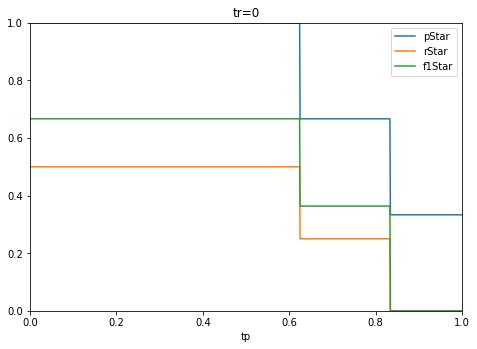

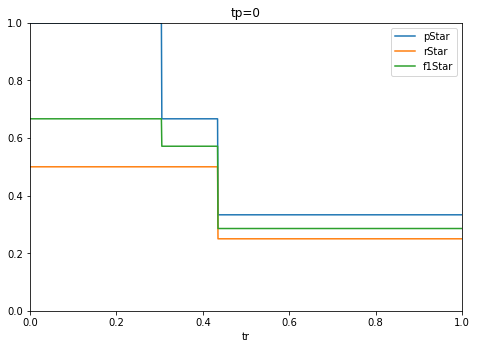

In [264]:
step=0.001

pStarTp, pStarTr, rStarTp, rStarTr, fStarTp, fStarTr = prfStar(yBinaryTrue,yBinaryPred,False,False,step)

t = np.arange(0,1+step,step)
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(t,pStarTp,label='pStar')
ax.plot(t,rStarTp,label='rStar')
ax.plot(t,fStarTp,label='f1Star')
ax.set_title('tr=0')
ax.set_xlabel('tp')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()
plt.show()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(t,pStarTr,label='pStar')
ax.plot(t,rStarTr,label='rStar')
ax.plot(t,fStarTr,label='f1Star')
ax.set_title('tp=0')
ax.set_xlabel('tr')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()
plt.show()

In [265]:
integralValues(fStarTp, fStarTr, step)

(0.4923333333333263, 0.4388571428571397, 0.465595238095233)

In [266]:
consecTrue = valuesConsecutive(yBinaryTrue,False)
consecPred = valuesConsecutive(yBinaryPred,False)
nbUnitsTrue = len(consecTrue)
nbUnitsPred = len(consecPred)
vectorStartTrue=np.array([consecTrue[i][1] for i in range(nbUnitsTrue)])
vectorStartPred=np.array([consecPred[i][1] for i in range(nbUnitsPred)])
matrixStartTrue=np.tile(vectorStartTrue, (nbUnitsPred,1)).transpose()
matrixStartPred=np.tile(vectorStartPred, (nbUnitsTrue,1))
vectorEndTrue=np.array([consecTrue[i][2] for i in range(nbUnitsTrue)])
vectorEndPred=np.array([consecPred[i][2] for i in range(nbUnitsPred)])
matrixEndTrue=np.tile(vectorEndTrue, (nbUnitsPred,1)).transpose()
matrixEndPred=np.tile(vectorEndPred, (nbUnitsTrue,1))
vectorClassTrue=np.array([consecTrue[i][0] for i in range(nbUnitsTrue)])
vectorClassPred=np.array([consecPred[i][0] for i in range(nbUnitsPred)])
matrixClassTrue=np.tile(vectorClassTrue, (nbUnitsPred,1)).transpose()
matrixClassPred=np.tile(vectorClassPred, (nbUnitsTrue,1))

In [267]:
matrixStartTrue

array([[ 6,  6,  6],
       [52, 52, 52],
       [71, 71, 71],
       [85, 85, 85]])

In [268]:
matrixStartPred

array([[10, 19, 51],
       [10, 19, 51],
       [10, 19, 51],
       [10, 19, 51]])

In [269]:
matrixEndTrue

array([[29, 29, 29],
       [57, 57, 57],
       [81, 81, 81],
       [90, 90, 90]])

In [270]:
matrixEndPred

array([[17, 31, 59],
       [17, 31, 59],
       [17, 31, 59],
       [17, 31, 59]])

In [271]:
matrixClassTrue

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [272]:
matrixClassPred

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [273]:
matrixPossibleMatches=(1-(matrixStartTrue >= matrixEndPred))*(1-(matrixStartPred >= matrixEndTrue))*(matrixClassTrue==matrixClassPred)

In [274]:
matrixPossibleMatches

array([[1, 1, 0],
       [0, 0, 1],
       [0, 0, 0],
       [0, 0, 0]])

In [275]:
a=np.where(matrixPossibleMatches[3,:])

In [276]:
list(a[0])

[]

In [277]:
for i in a[0]:
    print(i)

In [291]:
oldPRF1(yBinaryTrue, yBinaryPred, False, False, 13)

(1.0, 0.6, 0.7499999999999999)

In [279]:
marginUnitPRF1(yBinaryTrue, yBinaryPred, False, False, margin=13)

(1.0, 0.75, 0.8571428571428571)

In [284]:
oldPRF1adapted(yBinaryTrue, yBinaryPred, False, False, margin=10)

(1.0, 0.5, 0.6666666666666666)

In [302]:
marginMax=40
marginVector=np.arange(marginMax)
oldPRF1vector=np.zeros((marginMax,3))
oldPRF1adaptedvector=np.zeros((marginMax,3))
marginUnitPRF1vector=np.zeros((marginMax,3))

for i in range(marginMax):
    margin=marginVector[i]
    oldPRF1vector[i,0], oldPRF1vector[i,1], oldPRF1vector[i,2] = oldPRF1(yBinaryTrue, yBinaryPred, False, False, margin)
    oldPRF1adaptedvector[i,0], oldPRF1adaptedvector[i,1], oldPRF1adaptedvector[i,2] = oldPRF1adapted(yBinaryTrue, yBinaryPred, False, False, margin)
    marginUnitPRF1vector[i,0], marginUnitPRF1vector[i,1], marginUnitPRF1vector[i,2] = marginUnitPRF1(yBinaryTrue, yBinaryPred, False, False, margin)

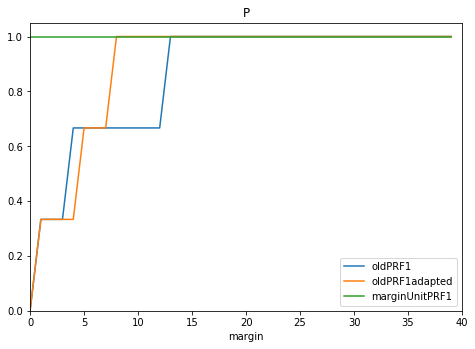

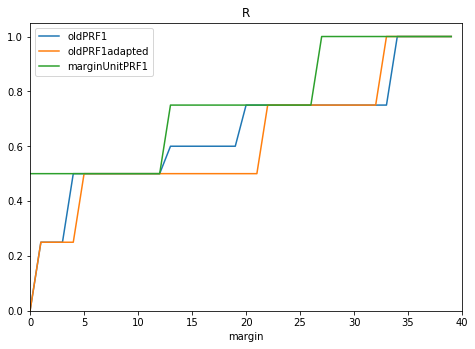

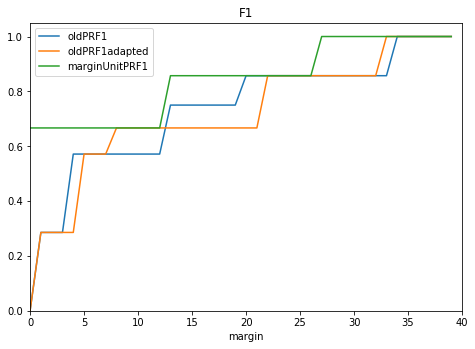

In [303]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(marginVector,oldPRF1vector[:,0],label='oldPRF1')
ax.plot(marginVector,oldPRF1adaptedvector[:,0],label='oldPRF1adapted')
ax.plot(marginVector,marginUnitPRF1vector[:,0],label='marginUnitPRF1')
ax.set_title('P')
ax.set_xlabel('margin')
ax.set_xlim(0,marginMax)
ax.set_ylim(0,1.05)
ax.legend()
plt.show()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(marginVector,oldPRF1vector[:,1],label='oldPRF1')
ax.plot(marginVector,oldPRF1adaptedvector[:,1],label='oldPRF1adapted')
ax.plot(marginVector,marginUnitPRF1vector[:,1],label='marginUnitPRF1')
ax.set_title('R')
ax.set_xlabel('margin')
ax.set_xlim(0,marginMax)
ax.set_ylim(0,1.05)
ax.legend()
plt.show()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(marginVector,oldPRF1vector[:,2],label='oldPRF1')
ax.plot(marginVector,oldPRF1adaptedvector[:,2],label='oldPRF1adapted')
ax.plot(marginVector,marginUnitPRF1vector[:,2],label='marginUnitPRF1')
ax.set_title('F1')
ax.set_xlabel('margin')
ax.set_xlim(0,marginMax)
ax.set_ylim(0,1.05)
ax.legend()
plt.show()

In [304]:
marginUnitPRF1vector

array([[1.        , 0.5       , 0.66666667],
       [1.        , 0.5       , 0.66666667],
       [1.        , 0.5       , 0.66666667],
       [1.        , 0.5       , 0.66666667],
       [1.        , 0.5       , 0.66666667],
       [1.        , 0.5       , 0.66666667],
       [1.        , 0.5       , 0.66666667],
       [1.        , 0.5       , 0.66666667],
       [1.        , 0.5       , 0.66666667],
       [1.        , 0.5       , 0.66666667],
       [1.        , 0.5       , 0.66666667],
       [1.        , 0.5       , 0.66666667],
       [1.        , 0.5       , 0.66666667],
       [1.        , 0.75      , 0.85714286],
       [1.        , 0.75      , 0.85714286],
       [1.        , 0.75      , 0.85714286],
       [1.        , 0.75      , 0.85714286],
       [1.        , 0.75      , 0.85714286],
       [1.        , 0.75      , 0.85714286],
       [1.        , 0.75      , 0.85714286],
       [1.        , 0.75      , 0.85714286],
       [1.        , 0.75      , 0.85714286],
       [1.